## Importar data

In [1]:
%pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error

importacion = pd.read_csv("importacion_volumen.csv", sep=';', encoding='ISO-8859-1')
consumo = pd.read_csv("consumo.csv", sep=';', encoding='ISO-8859-1')
precios = pd.read_csv("precio_promedio.csv", sep=';', encoding='ISO-8859-1')

/tmp/ipykernel_77493/3230215532.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
Importing plotly failed. Interactive plots will not work.


In [3]:
importacion = importacion[['Fecha','Diesel bajo azufre', 'Gas licuado de petróleo','Gasolina regular', 'Gasolina superior']]
importacion = importacion.rename(columns={'Diesel bajo azufre': 'Diesel'})
importacion = importacion.rename(columns={'Gasolina regular': 'Regular'})
importacion = importacion.rename(columns={'Gasolina superior': 'Superior'})
importacion = importacion.rename(columns={'Gas licuado de petróleo': 'GLP'})

consumo = consumo[['Fecha','Diesel bajo azufre', 'Gas licuado de petróleo','Gasolina regular', 'Gasolina superior']]
consumo = consumo.rename(columns={'Diesel bajo azufre': 'Diesel'})
consumo = consumo.rename(columns={'Gasolina regular': 'Regular'})
consumo = consumo.rename(columns={'Gasolina superior': 'Superior'})
consumo = consumo.rename(columns={'Gas licuado de petróleo': 'GLP'})

precios = precios[['FECHA','Diesel', 'Glp Cilindro 25Lbs.','Regular', 'Superior']]
precios = precios.rename(columns={'FECHA': 'Fecha'})
precios = precios.rename(columns={'Glp Cilindro 25Lbs.': 'GLP'})

In [4]:
importacion.head(3)

Fecha Diesel         GLP     Regular    Superior
0  ene-01      0  194,065.74  177,776.50  373,963.96
1  feb-01      0  170,703.38  123,115.99  243,091.07
2  mar-01      0  161,837.37  161,726.42  312,084.38

In [5]:
consumo.head(3)

Fecha Diesel         GLP     Regular    Superior
0  ene/2000   0.00  194,410.48  202,645.20  308,156.82
1  feb/2000   0.00  174,710.55  205,530.96  307,766.31
2  mar/2000   0.00  189,234.07  229,499.56  331,910.29

In [6]:
precios.head(3)

Fecha  Diesel   GLP  Regular  Superior
0  01/ene/2021   17.61  99.0    21.11     21.91
1  02/ene/2021   17.61  99.0    21.11     21.91
2  03/ene/2021   17.61  99.0    21.11     21.91

## EDA

### Funciones útiles

In [7]:
# Función para convertir columnas object a float si aplica.
def convert_objects_to_float(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='ignore')
    return df

In [8]:
# Mapeo de meses según diminutivo
month_translation = {
    'ene': 'Enero', 'feb': 'Febrero', 'mar': 'Marzo', 'abr': 'Abril',
    'may': 'Mayo', 'jun': 'Junio', 'jul': 'Julio', 'ago': 'Agosto',
    'sep': 'Septiembre', 'oct': 'Octubre', 'nov': 'Noviembre', 'dic': 'Diciembre'
}

# Función para dividir fecha en Mes, Año
def split_date(date_str, sep):
  parts = date_str.split(sep)
  if len(parts) == 2:
    month_abbr, year_suffix = parts
  else:
    day, month_abbr, year_suffix = parts
  month = month_translation.get(month_abbr, 'Unknown')
  year = '20' + year_suffix if int(year_suffix) < 100 else year_suffix
  year = int(year)
  if len(parts) == 3:
    return pd.Series([day, month, year], index=['Day','Month','Year'])
  return pd.Series([month, year], index=['Month', 'Year'])

In [9]:
# Función para aplicar test de Shapiro Wilk y determinar si las variables están distribuidas normalmente.
def shapiro_wilk_test(df):  
  results = {}
  for column in importacion.select_dtypes(include=['float64', 'int64']).columns:
      stat, p_value = stats.shapiro(importacion[column])
      results[column] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}

  conclusion = pd.DataFrame(results).T
  
  return conclusion

### DF Importacion

In [10]:
importacion = convert_objects_to_float(importacion)
importacion[['Mes','Año']] = importacion['Fecha'].apply(lambda x: split_date(x, '-'))
importacion = importacion.drop(columns=['Fecha'])
importacion.head()

/tmp/ipykernel_77493/540744732.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Diesel        GLP    Regular   Superior      Mes   Año
0     0.0  194065.74  177776.50  373963.96    Enero  2001
1     0.0  170703.38  123115.99  243091.07  Febrero  2001
2     0.0  161837.37  161726.42  312084.38    Marzo  2001
3     0.0  163048.64  127338.74  285054.89    Abril  2001
4     0.0  171518.86  168730.19  300913.67     Mayo  2001

In [11]:
print(shapiro_wilk_test(importacion))

          Shapiro-Wilk Statistic       p-value
Diesel                  0.614493  1.112924e-24
GLP                     0.956727  1.985218e-07
Regular                 0.903416  1.834356e-12
Superior                0.972090  2.626834e-05
Año                     0.952219  5.717011e-08


In [12]:
profile = ProfileReport(importacion, title="Profiling", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
# Calcular los meses en los que hay más importaciones:
importacion['Total'] = importacion[['Diesel', 'Regular', 'Superior']].sum(axis=1)
importacion_mensual = importacion.groupby(['Mes'])['Total'].sum().reset_index()
top_meses = importacion_mensual.sort_values(by='Total', ascending=False)

print("Meses con más importaciones:")
print(top_meses[['Mes', 'Total']])

Meses con más importaciones:
           Mes        Total
7        Marzo  32425166.65
3        Enero  31192465.07
8         Mayo  30175525.42
0        Abril  29887144.22
4      Febrero  29458108.13
6        Junio  28516901.76
2    Diciembre  28363938.01
10     Octubre  27183429.77
9    Noviembre  26710614.33
1       Agosto  25765217.53
5        Julio  25583365.72
11  Septiembre  24720985.95


In [14]:
# Picos en importaciones por año y por tipo de combustibles

importacion['Total'] = importacion[['Diesel', 'Regular', 'Superior']].sum(axis=1)
def find_peak_per_year(df, column):
    peaks = df.loc[df.groupby('Año')[column].idxmax()]
    peaks_filtered = peaks[peaks[column] > 0]
    return peaks_filtered[['Año', 'Mes', column]]

In [15]:
peaks_diesel = find_peak_per_year(importacion, 'Diesel')
print("Picos en importaciones de diesel por año:")
print(peaks_diesel)

Picos en importaciones de diesel por año:
      Año        Mes      Diesel
208  2018       Mayo  1592580.34
218  2019      Marzo  1550052.84
230  2020      Marzo  1367335.14
249  2021    Octubre  1542473.57
252  2022      Enero  1438571.28
275  2023  Diciembre  1509634.28
278  2024      Marzo  1477038.00


In [16]:
peaks_regular = find_peak_per_year(importacion, 'Regular')
print("\nPicos en importaciones de regular por año:")
print(peaks_regular)


Picos en importaciones de regular por año:
      Año         Mes    Regular
8    2001  Septiembre  233643.75
18   2002       Julio  222408.00
28   2003        Mayo  269981.86
38   2004       Marzo  275539.38
58   2005   Noviembre  266018.37
68   2006  Septiembre  366193.77
79   2007      Agosto  351306.27
93   2008     Octubre  358036.44
97   2009     Febrero  588346.36
111  2010       Abril  433108.23
131  2011   Diciembre  367820.54
141  2012     Octubre  374301.51
146  2013       Marzo  439386.62
167  2014   Diciembre  491072.11
178  2015   Noviembre  574547.76
188  2016  Septiembre  567786.57
195  2017       Abril  681303.11
213  2018     Octubre  726044.35
223  2019      Agosto  896841.31
237  2020     Octubre  861840.54
248  2021  Septiembre  844430.03
258  2022       Julio  987872.05
268  2023        Mayo  947633.29
280  2024        Mayo  939656.18


In [17]:
peaks_superior = find_peak_per_year(importacion, 'Superior')
print("\nPicos en importaciones de superior por año:")
print(peaks_superior)


Picos en importaciones de superior por año:
      Año        Mes    Superior
0    2001      Enero   373963.96
23   2002  Diciembre   440677.81
28   2003       Mayo   459025.69
38   2004      Marzo   486880.82
55   2005     Agosto   566618.55
60   2006      Enero   711860.77
76   2007       Mayo   545587.63
87   2008      Abril   570256.98
105  2009    Octubre   639524.61
119  2010  Diciembre   652210.77
131  2011  Diciembre   534925.36
141  2012    Octubre   600094.03
148  2013       Mayo   532379.66
167  2014  Diciembre   583081.57
178  2015  Noviembre   724273.97
182  2016      Marzo   771024.11
203  2017  Diciembre   803216.88
210  2018      Julio   784601.77
227  2019  Diciembre   797580.75
230  2020      Marzo   809640.18
243  2021      Abril  1227173.53
252  2022      Enero   947226.27
265  2023    Febrero   685183.06
276  2024      Enero   712333.33


### DF Consumo

In [18]:
consumo = convert_objects_to_float(consumo)
consumo[['Mes','Año']] = consumo['Fecha'].apply(lambda x: split_date(x, '/'))
consumo = consumo.drop(columns=['Fecha'])
consumo.head()

/tmp/ipykernel_77493/540744732.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Diesel        GLP    Regular   Superior      Mes   Año
0     0.0  194410.48  202645.20  308156.82    Enero  2000
1     0.0  174710.55  205530.96  307766.31  Febrero  2000
2     0.0  189234.07  229499.56  331910.29    Marzo  2000
3     0.0  174330.61  210680.40  315648.08    Abril  2000
4     0.0  191745.15  208164.34  319667.97     Mayo  2000

In [19]:
print(shapiro_wilk_test(consumo))

          Shapiro-Wilk Statistic       p-value
Diesel                  0.614493  1.112924e-24
GLP                     0.956727  1.985218e-07
Regular                 0.903416  1.834356e-12
Superior                0.972090  2.626834e-05
Año                     0.952219  5.717011e-08
Total                   0.804122  3.842864e-18


In [20]:
profile = ProfileReport(consumo, title="Profiling", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### DF Precios

In [21]:
precios.head()

Fecha  Diesel   GLP  Regular  Superior
0  01/ene/2021   17.61  99.0    21.11     21.91
1  02/ene/2021   17.61  99.0    21.11     21.91
2  03/ene/2021   17.61  99.0    21.11     21.91
3  04/ene/2021   17.61  99.0    21.11     21.91
4  05/ene/2021   17.61  99.0    21.11     21.91

In [22]:
precios = convert_objects_to_float(precios)
precios[['Día','Mes','Año']] = precios['Fecha'].apply(lambda x: split_date(x, '/'))
precios = precios.drop(columns=['Fecha'])
precios.head()

/tmp/ipykernel_77493/540744732.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Diesel   GLP  Regular  Superior Día    Mes   Año
0   17.61  99.0    21.11     21.91  01  Enero  2021
1   17.61  99.0    21.11     21.91  02  Enero  2021
2   17.61  99.0    21.11     21.91  03  Enero  2021
3   17.61  99.0    21.11     21.91  04  Enero  2021
4   17.61  99.0    21.11     21.91  05  Enero  2021

In [23]:
print(shapiro_wilk_test(precios))

          Shapiro-Wilk Statistic       p-value
Diesel                  0.614493  1.112924e-24
GLP                     0.956727  1.985218e-07
Regular                 0.903416  1.834356e-12
Superior                0.972090  2.626834e-05
Año                     0.952219  5.717011e-08
Total                   0.804122  3.842864e-18


In [24]:
profile = ProfileReport(precios, title="Profiling", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Trabajo de Series

#### Serie 1: Precios en ciudad capital de Diesel

In [25]:
meses = {
    'Enero': '01',
    'Febrero': '02',
    'Marzo': '03',
    'Abril': '04',
    'Mayo': '05',
    'Junio': '06',
    'Julio': '07',
    'Agosto': '08',
    'Septiembre': '09',
    'Octubre': '10',
    'Noviembre': '11',
    'Diciembre': '12'
}

In [26]:
serie_precios = precios.copy()
serie_precios['Mes'] = serie_precios['Mes'].map(meses)

serie_precios['Fecha'] = pd.to_datetime(serie_precios['Día'].astype(str) + '-' + serie_precios['Mes'] + '-' + serie_precios['Año'].astype(str), format='%d-%m-%Y')
serie_precios.set_index('Fecha', inplace=True)

serie_precios.head()

Diesel   GLP  Regular  Superior Día Mes   Año
Fecha                                                    
2021-01-01   17.61  99.0    21.11     21.91  01  01  2021
2021-01-02   17.61  99.0    21.11     21.91  02  01  2021
2021-01-03   17.61  99.0    21.11     21.91  03  01  2021
2021-01-04   17.61  99.0    21.11     21.91  04  01  2021
2021-01-05   17.61  99.0    21.11     21.91  05  01  2021

In [27]:
serie_precios = serie_precios[['Diesel']]  # Seleccionamos solo la columna de interés

# Especificar Inicio, fin, y frecuencia
inicio = serie_precios.index.min()
fin = serie_precios.index.max()
frecuencia = serie_precios.index.to_series().diff().mode()[0]

print(f'Inicio: {inicio}\nFin: {fin}\nFrecuencia: {frecuencia}')


Inicio: 2021-01-01 00:00:00
Fin: 2024-08-18 00:00:00
Frecuencia: 1 days 00:00:00


In [28]:
serie_precios = serie_precios.asfreq('D')

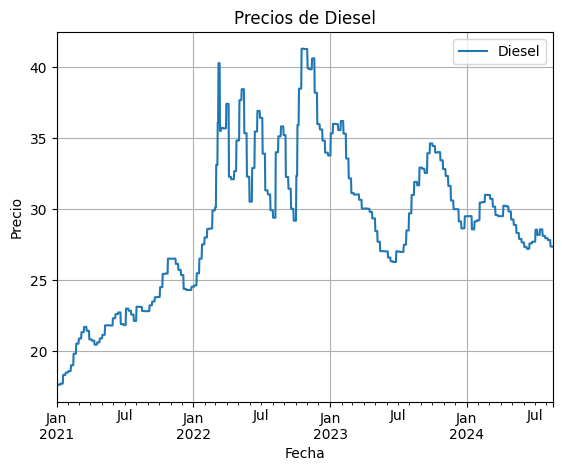

In [29]:
serie_precios.plot()
plt.title('Precios de Diesel')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

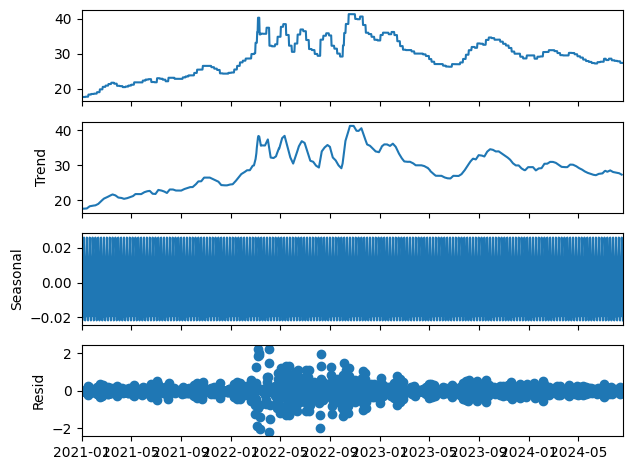

In [30]:
result_precios = seasonal_decompose(serie_precios)
result_precios.plot()
plt.show()

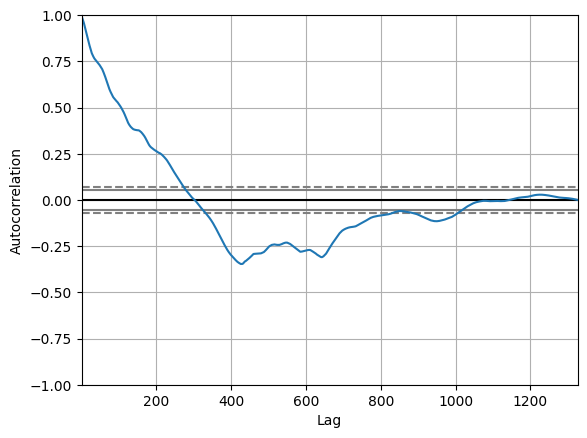

In [31]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(serie_precios)
plt.show()


In [32]:
result = adfuller(serie_precios['Diesel'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: -2.389344056123274
p: 0.1447665848694608


In [33]:
serie_precios['Diesel'] = serie_precios['Diesel'].diff().dropna()
result = adfuller(serie_precios['Diesel'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: -7.151926081520954
p: 3.1249726974732356e-10


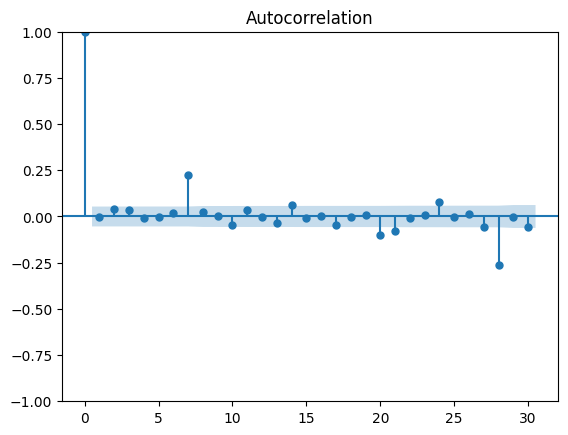

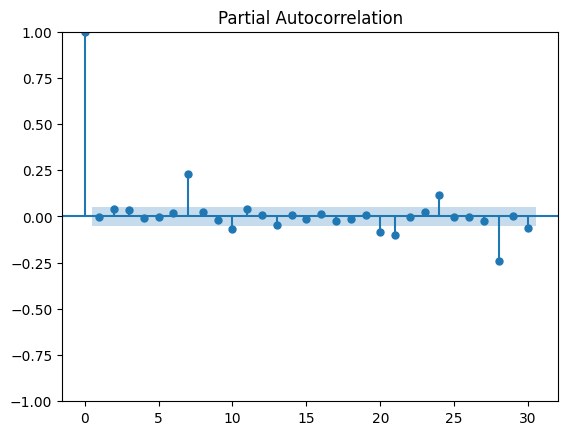

In [34]:
plot_acf(serie_precios['Diesel'].dropna(), lags=30)
plot_pacf(serie_precios['Diesel'].dropna(), lags=30)
plt.show()

In [35]:
# Mejor alternativa encontrada: (p = 2, d = 2, q = 23)
model_arima = ARIMA(serie_precios['Diesel'].dropna(), order=(2, 2, 23))
model_arima_fit = model_arima.fit()

print(f'AIC: {model_arima_fit.aic}')
print(f'BIC: {model_arima_fit.bic}')

forecast_arima = model_arima_fit.forecast(steps=200)


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 1723.5553983493555
BIC: 1858.4344846163444


In [36]:
prophet_precios_df = serie_precios['Diesel'].dropna().reset_index().rename(columns={'Fecha': 'ds', 'Diesel': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_precios_df)

future = model_prophet.make_future_dataframe(periods=365)
forecast_prophet = model_prophet.predict(future)

forecast_prophet = forecast_prophet[['ds', 'yhat']]


20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing


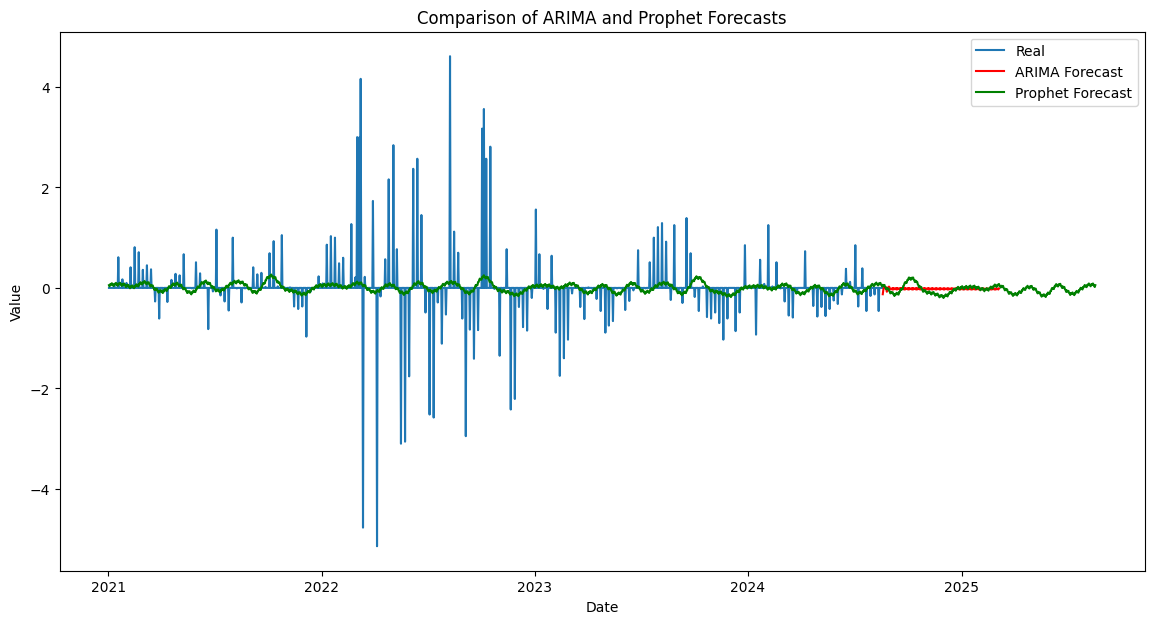

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(serie_precios.index, serie_precios['Diesel'], label='Real')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')

# Plot Prophet predictions
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of ARIMA and Prophet Forecasts')
plt.show()


In [38]:
train = serie_precios.loc[:'2023-12-31']
test = serie_precios.loc['2024-01-01':]


In [39]:
model_arima = ARIMA(train['Diesel'].dropna(), order=((2, 2, 23)))
model_arima_fit = model_arima.fit()

# Realizar la predicción para los últimos 3 años (365*3 = 1095 días aproximadamente)
forecast_arima = model_arima_fit.forecast(steps=len(test))


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
test = test.copy()
test['forecast'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast'] = forecast_arima

rmse = np.sqrt(mean_squared_error(test['Diesel'].dropna(), test['forecast'].dropna()))
print(f'RMSE: {rmse}')


RMSE: 0.18173077623815828


In [41]:
df_prophet = serie_precios.reset_index().rename(columns={'Fecha': 'ds', 'Diesel': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test), freq='D')
forecast_prophet = model_prophet.predict(future)

test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test['Diesel']
})

forecast_prophet.set_index('ds', inplace=True)
test_prophet['forecast'] = forecast_prophet.loc[test.index, 'yhat']

y_pred = test_prophet['forecast'].values
y_true = test_prophet['y'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.18948863091280818


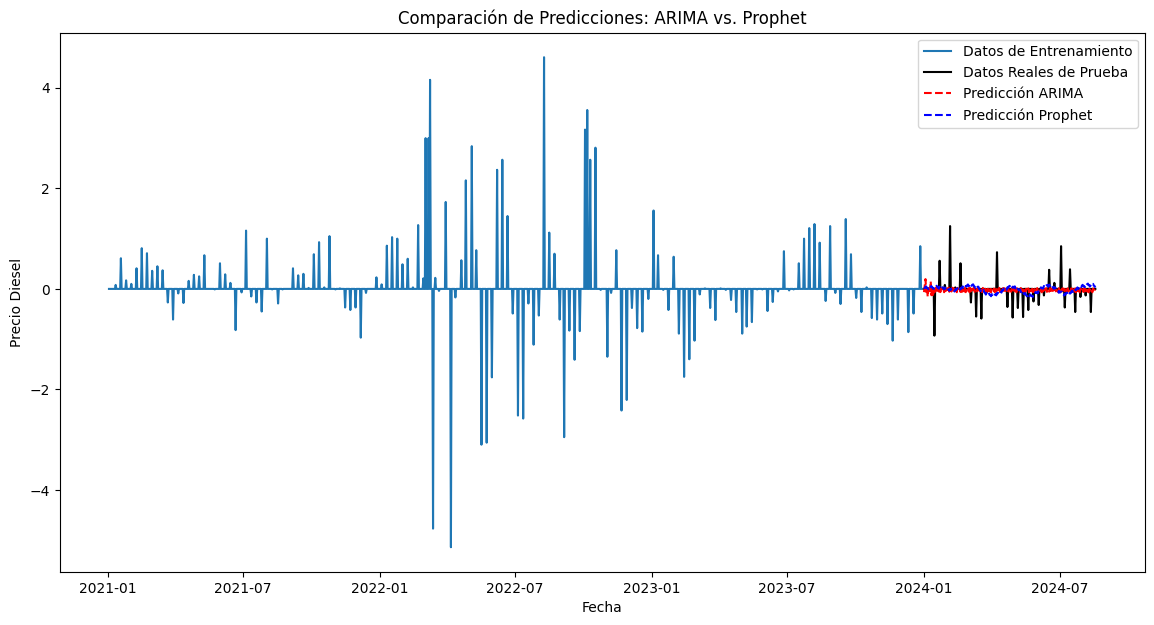

In [42]:
test['forecast_arima'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast_arima'] = forecast_arima

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Diesel'], label='Datos de Entrenamiento')
plt.plot(test.index, test['Diesel'], label='Datos Reales de Prueba', color='black')

plt.plot(test.index, test['forecast_arima'], label='Predicción ARIMA', linestyle='--', color='red')
plt.plot(test_prophet['ds'], test_prophet['forecast'], label='Predicción Prophet', linestyle='--', color='blue')

plt.legend()
plt.title('Comparación de Predicciones: ARIMA vs. Prophet')
plt.xlabel('Fecha')
plt.ylabel('Precio Diesel')
plt.show()


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


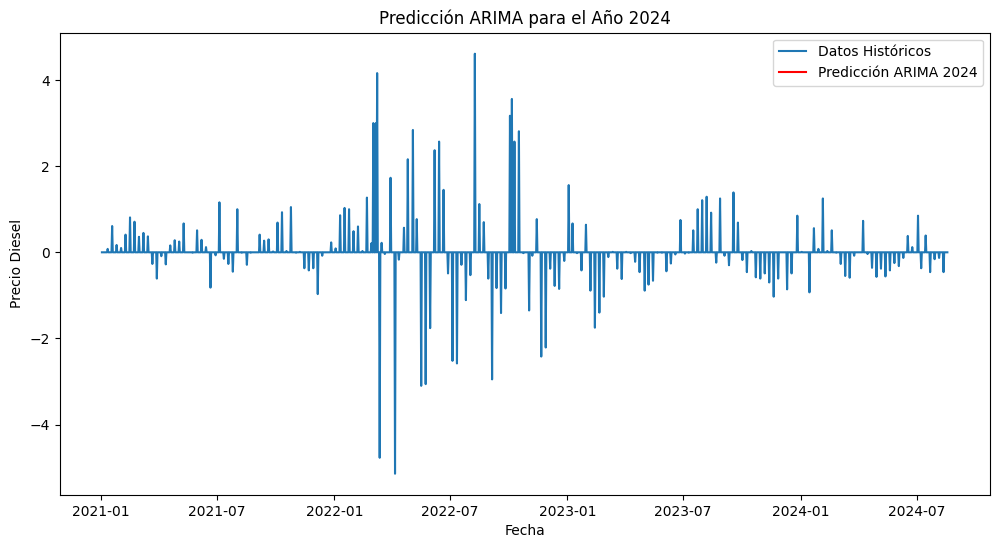

In [43]:
model_arima = ARIMA(serie_precios['Diesel'].dropna(), order=(2, 2, 23))
model_arima_fit = model_arima.fit()

start_date = '2024-01-01'
end_date = '2024-12-31'
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
future_df = pd.DataFrame(index=future_dates)

forecast_arima = model_arima_fit.predict(start=future_df.index[0], end=future_df.index[-1], dynamic=False)
forecast_df = pd.DataFrame(forecast_arima, index=future_df.index, columns=['Forecast'])

plt.figure(figsize=(12, 6))
plt.plot(serie_precios.index, serie_precios['Diesel'], label='Datos Históricos')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Predicción ARIMA 2024', color='red')
plt.xlabel('Fecha')
plt.ylabel('Precio Diesel')
plt.title('Predicción ARIMA para el Año 2024')
plt.legend()
plt.show()

#### Serie 2: Consumo mensual de gasolina Regular

In [44]:
serie_consumo = consumo.copy()
serie_consumo['Mes'] = serie_consumo['Mes'].map(meses)

serie_consumo['Fecha'] = pd.to_datetime(serie_consumo['Año'].astype(str) + '-' + serie_consumo['Mes'] + '-01', format='%Y-%m-%d')
serie_consumo.set_index('Fecha', inplace=True)

serie_consumo.head()

Diesel        GLP    Regular   Superior Mes   Año
Fecha                                                        
2000-01-01     0.0  194410.48  202645.20  308156.82  01  2000
2000-02-01     0.0  174710.55  205530.96  307766.31  02  2000
2000-03-01     0.0  189234.07  229499.56  331910.29  03  2000
2000-04-01     0.0  174330.61  210680.40  315648.08  04  2000
2000-05-01     0.0  191745.15  208164.34  319667.97  05  2000

In [45]:
serie_consumo = serie_consumo[['Regular']] 

inicio = serie_consumo.index.min()
fin = serie_consumo.index.max()
frecuencia = serie_consumo.index.to_series().diff().mode()[0]

print(f'Inicio: {inicio}\nFin: {fin}\nFrecuencia: {frecuencia}')


Inicio: 2000-01-01 00:00:00
Fin: 2024-06-01 00:00:00
Frecuencia: 31 days 00:00:00


In [46]:
serie_consumo = serie_consumo.asfreq('MS')

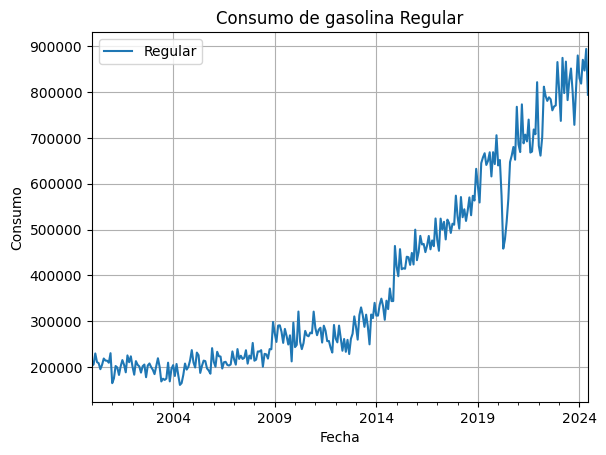

In [47]:
serie_consumo.plot()
plt.title('Consumo de gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.show()

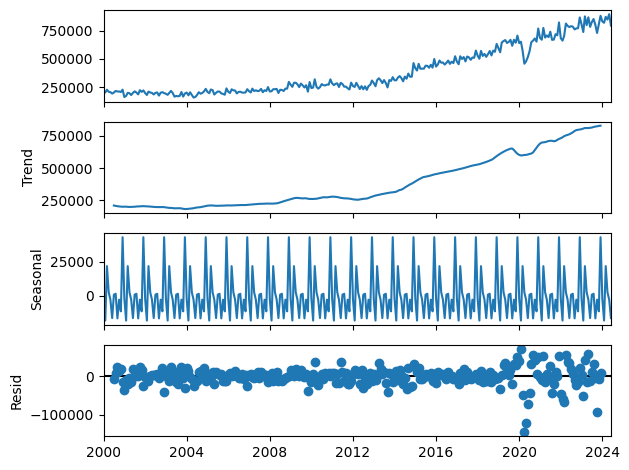

In [48]:
result_consumo = seasonal_decompose(serie_consumo)
result_consumo.plot()
plt.show()

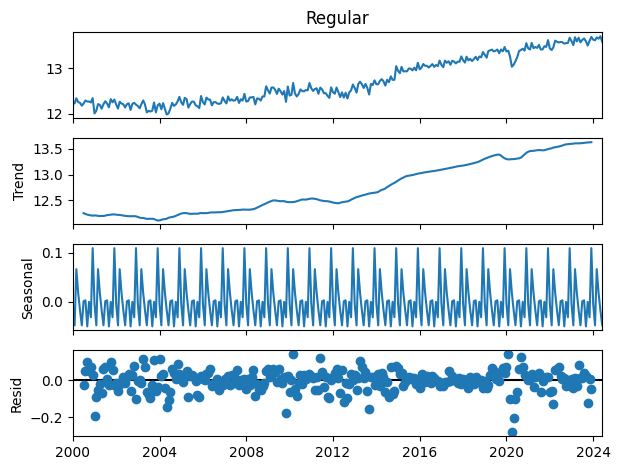

In [49]:
serie_consumo_log = serie_consumo['Regular'].apply(lambda x: np.log(x + 1))

result_consumo_log = seasonal_decompose(serie_consumo_log)
result_consumo_log.plot()
plt.show()

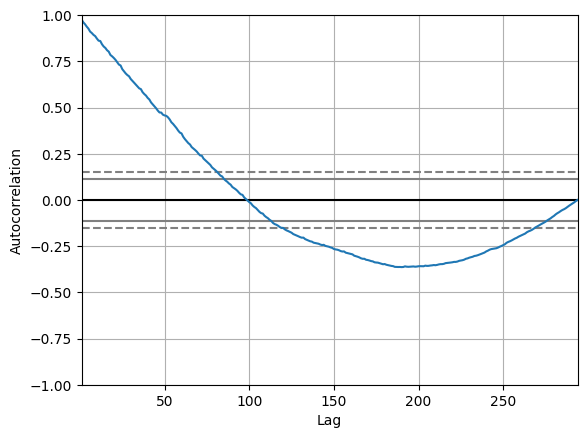

In [50]:
autocorrelation_plot(serie_consumo)
plt.show()

In [51]:
result = adfuller(serie_consumo['Regular'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: 2.430668662105455
p: 0.9990240194279522


In [52]:
serie_consumo['Regular'] = serie_consumo['Regular'].diff().dropna()
result = adfuller(serie_consumo['Regular'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: -4.2842159583043635
p: 0.00047301579144935795


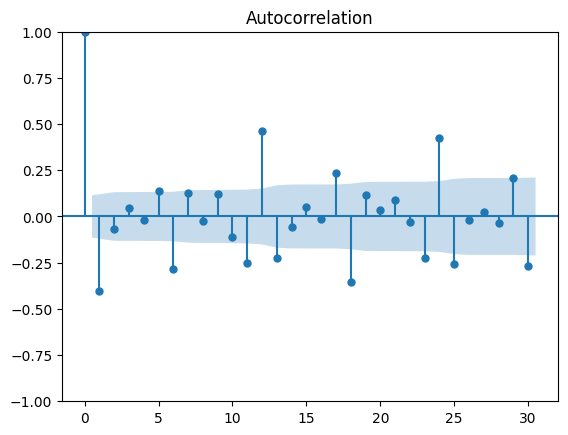

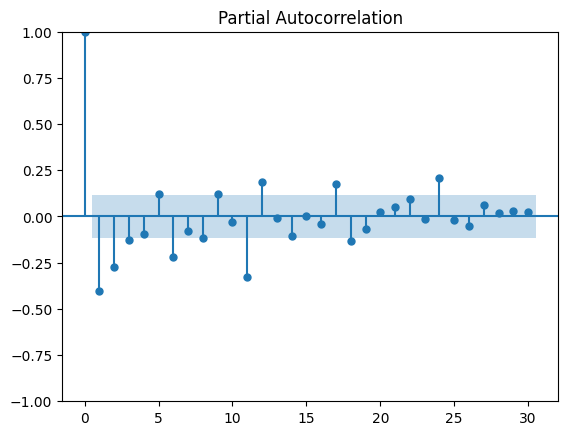

In [53]:
plot_acf(serie_consumo['Regular'].dropna(), lags=30)
plot_pacf(serie_consumo['Regular'].dropna(), lags=30)
plt.show()

In [54]:
# Mejor alternativa encontrada: (p = 4, d = 2, q = 16)
model_arima = ARIMA(serie_consumo['Regular'].dropna(), order=(4, 2, 16))
model_arima_fit = model_arima.fit()

print(f'AIC: {model_arima_fit.aic}')
print(f'BIC: {model_arima_fit.bic}')

forecast_arima = model_arima_fit.forecast(steps=200)


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 6870.476951942879
BIC: 6947.616740553481


In [55]:
prophet_consumo_df = serie_consumo['Regular'].dropna().reset_index().rename(columns={'Fecha': 'ds', 'Regular': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_consumo_df)

future = model_prophet.make_future_dataframe(periods=1000)
forecast_prophet = model_prophet.predict(future)

forecast_prophet = forecast_prophet[['ds', 'yhat']]


20:32:02 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing


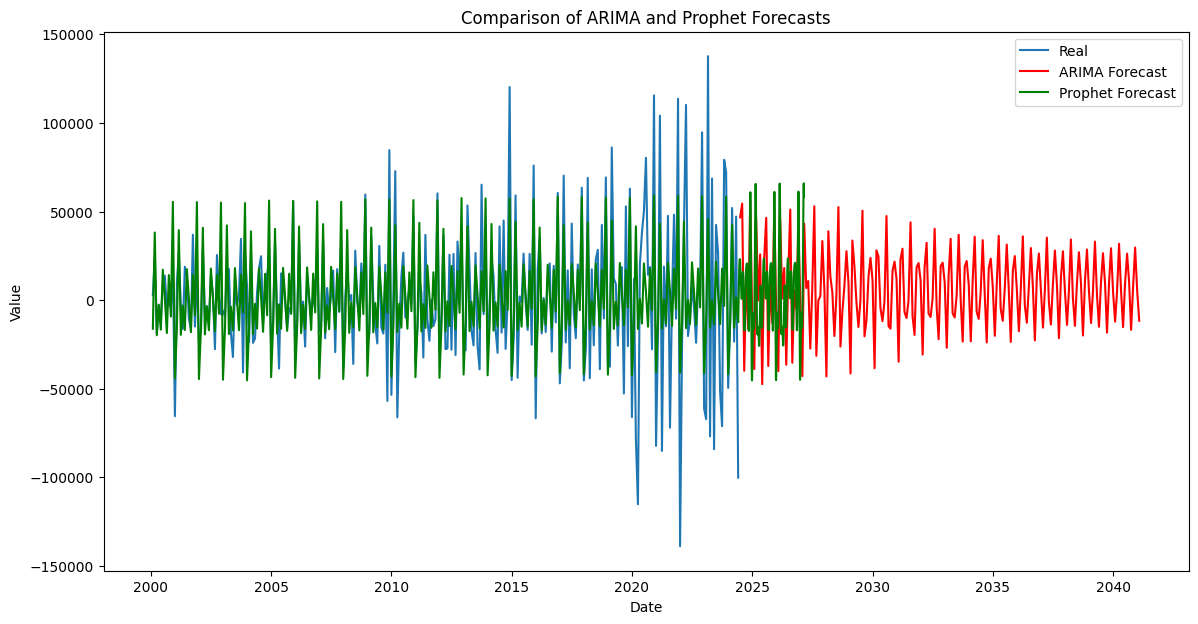

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(serie_consumo.index, serie_consumo['Regular'], label='Real')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')

# Plot Prophet predictions
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of ARIMA and Prophet Forecasts')
plt.show()

In [57]:
train = serie_consumo.loc[:'2021-12-01']
test = serie_consumo.loc['2022-01-01':]


In [58]:
model_arima = ARIMA(train['Regular'].dropna(), order=((4, 2, 16)))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
test = test.copy()
test['forecast'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast'] = forecast_arima

rmse = np.sqrt(mean_squared_error(test['Regular'].dropna(), test['forecast'].dropna()))
print(f'RMSE: {rmse}')


RMSE: 59827.3623008515


In [60]:
df_prophet = serie_consumo.reset_index().rename(columns={'Fecha': 'ds', 'Regular': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test), freq='D')
forecast_prophet = model_prophet.predict(future)

test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test['Regular']
})

forecast_prophet.set_index('ds', inplace=True)
test_prophet['forecast'] = forecast_prophet.loc[test.index, 'yhat']

y_pred = test_prophet['forecast'].values
y_true = test_prophet['y'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 51812.97842391152


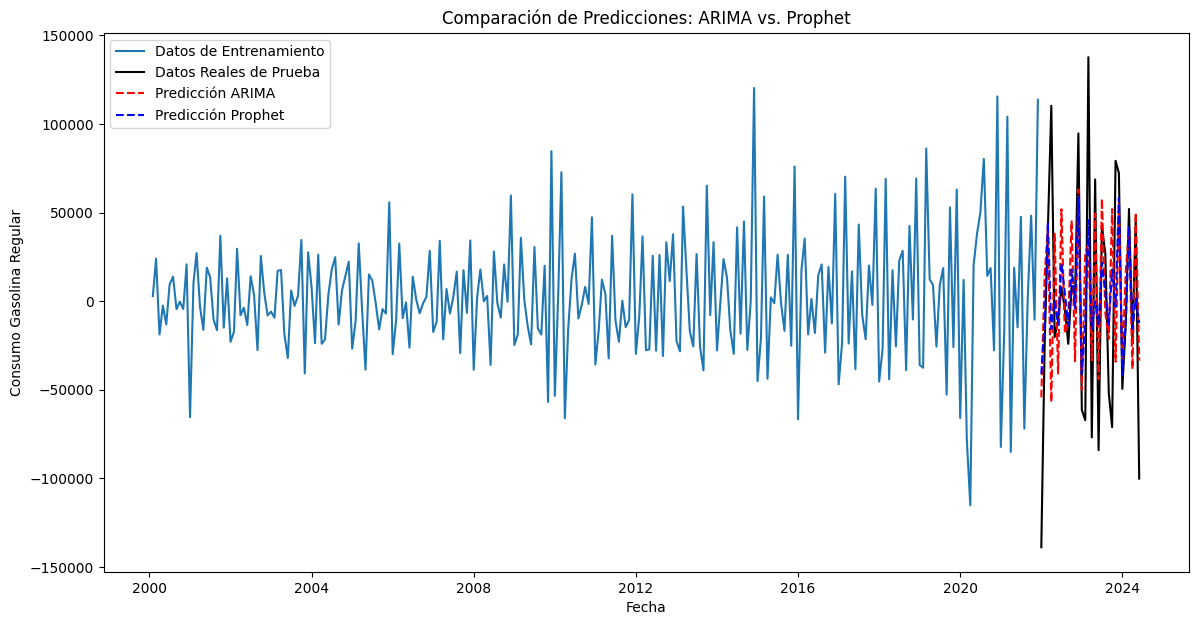

In [61]:
test['forecast_arima'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast_arima'] = forecast_arima

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Regular'], label='Datos de Entrenamiento')
plt.plot(test.index, test['Regular'], label='Datos Reales de Prueba', color='black')

plt.plot(test.index, test['forecast_arima'], label='Predicción ARIMA', linestyle='--', color='red')
plt.plot(test_prophet['ds'], test_prophet['forecast'], label='Predicción Prophet', linestyle='--', color='blue')

plt.legend()
plt.title('Comparación de Predicciones: ARIMA vs. Prophet')
plt.xlabel('Fecha')
plt.ylabel('Consumo Gasolina Regular')
plt.show()


#### Serie 3: Importación mensual de gasolina Regular

In [62]:
serie_importacion = importacion.copy()
serie_importacion['Mes'] = serie_importacion['Mes'].map(meses)

serie_importacion['Fecha'] = pd.to_datetime(serie_importacion['Año'].astype(str) + '-' + serie_importacion['Mes'] + '-01', format='%Y-%m-%d')
serie_importacion.set_index('Fecha', inplace=True)

serie_importacion.head()

Diesel        GLP    Regular   Superior Mes   Año      Total
Fecha                                                                   
2001-01-01     0.0  194065.74  177776.50  373963.96  01  2001  551740.46
2001-02-01     0.0  170703.38  123115.99  243091.07  02  2001  366207.06
2001-03-01     0.0  161837.37  161726.42  312084.38  03  2001  473810.80
2001-04-01     0.0  163048.64  127338.74  285054.89  04  2001  412393.63
2001-05-01     0.0  171518.86  168730.19  300913.67  05  2001  469643.86

In [63]:
serie_importacion = serie_importacion[['Regular']] 

inicio = serie_importacion.index.min()
fin = serie_importacion.index.max()
frecuencia = serie_importacion.index.to_series().diff().mode()[0]

print(f'Inicio: {inicio}\nFin: {fin}\nFrecuencia: {frecuencia}')

Inicio: 2001-01-01 00:00:00
Fin: 2024-06-01 00:00:00
Frecuencia: 31 days 00:00:00


In [64]:
serie_importacion = serie_importacion.asfreq('MS')

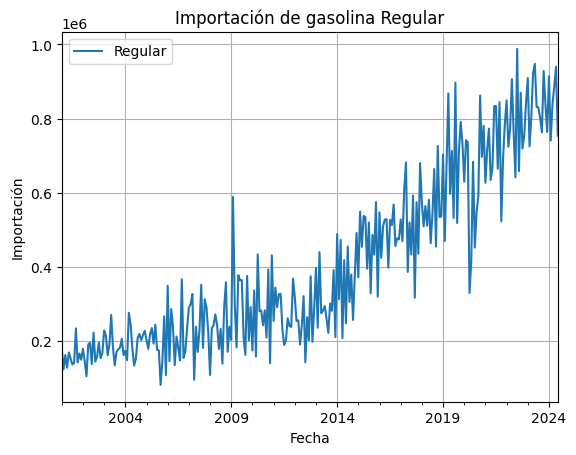

In [65]:
serie_importacion.plot()
plt.title('Importación de gasolina Regular')
plt.xlabel('Fecha')
plt.ylabel('Importación')
plt.grid(True)
plt.show()

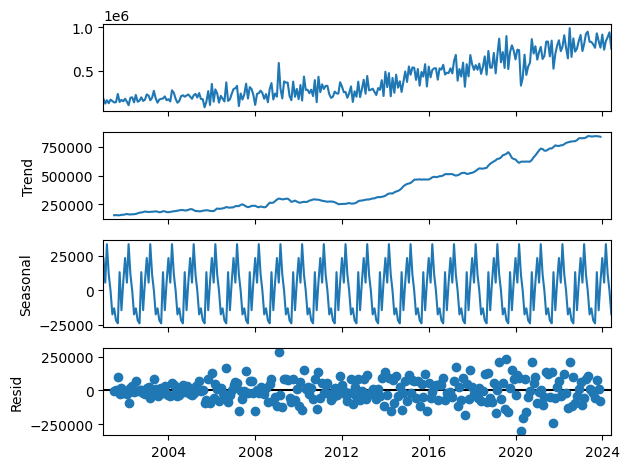

In [66]:
result_importación = seasonal_decompose(serie_importacion)
result_importación.plot()
plt.show()

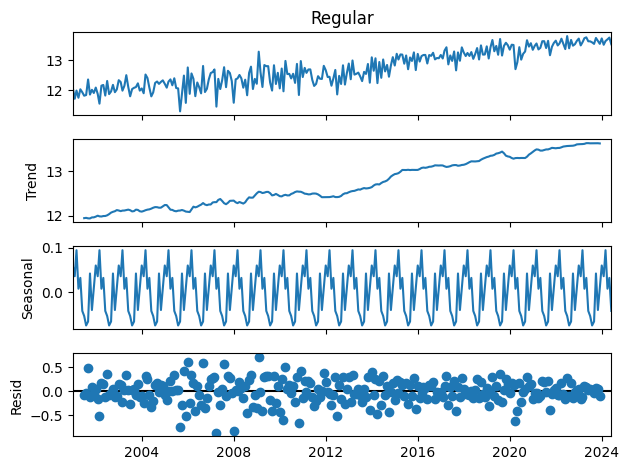

In [67]:
serie_importacion_log = serie_importacion['Regular'].apply(lambda x: np.log(x + 1))

result_importacion_log = seasonal_decompose(serie_importacion_log)
result_importacion_log.plot()
plt.show()

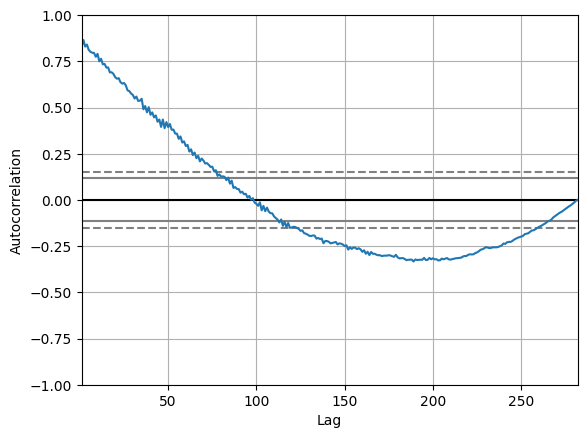

In [68]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(serie_importacion)
plt.show()

In [69]:
result = adfuller(serie_importacion['Regular'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: 0.7073528870703516
p: 0.9899834724841569


In [70]:
serie_importacion['Regular'] = serie_importacion['Regular'].diff().dropna()
result = adfuller(serie_importacion['Regular'].dropna())
print(f'ADF: {result[0]}')
print(f'p: {result[1]}')

ADF: -10.172801820584626
p: 7.017463931407933e-18


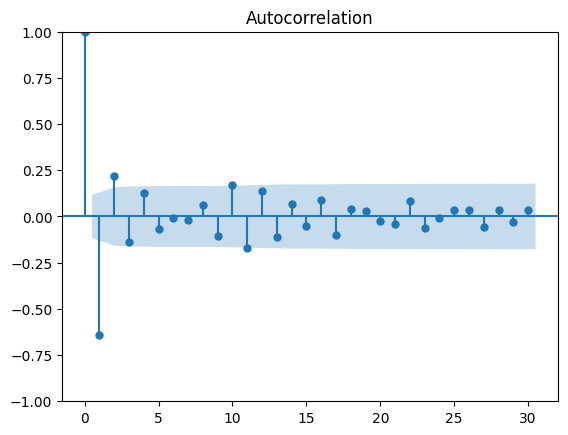

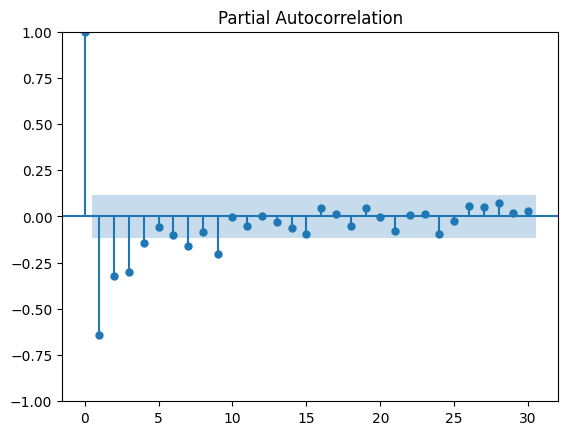

In [71]:
plot_acf(serie_importacion['Regular'].dropna(), lags=30)
plot_pacf(serie_importacion['Regular'].dropna(), lags=30)
plt.show()

In [72]:
# Mejor alternativa encontrada: (p = 1, d = 2, q = 26)
model_arima = ARIMA(serie_importacion['Regular'].dropna(), order=(1, 2, 26))
model_arima_fit = model_arima.fit()

print(f'AIC: {model_arima_fit.aic}')
print(f'BIC: {model_arima_fit.bic}')

forecast_arima = model_arima_fit.forecast(steps=100)


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 7328.591708064175
BIC: 7430.265637955173


In [73]:
prophet_importacion_df = serie_importacion['Regular'].dropna().reset_index().rename(columns={'Fecha': 'ds', 'Regular': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_importacion_df)

future = model_prophet.make_future_dataframe(periods=365)
forecast_prophet = model_prophet.predict(future)

forecast_prophet = forecast_prophet[['ds', 'yhat']]


20:32:26 - cmdstanpy - INFO - Chain [1] start processing
20:32:26 - cmdstanpy - INFO - Chain [1] done processing


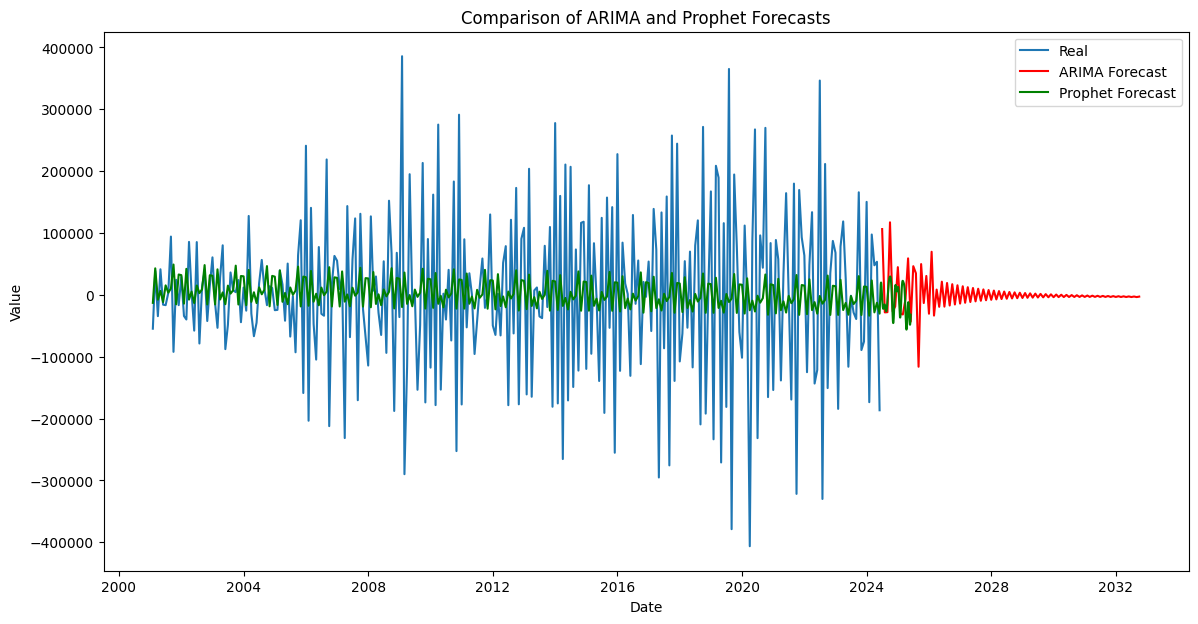

In [74]:
plt.figure(figsize=(14, 7))
plt.plot(serie_importacion.index, serie_importacion['Regular'], label='Real')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')

plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of ARIMA and Prophet Forecasts')
plt.show()


In [75]:
train = serie_importacion.loc[:'2021-12-01']
test = serie_importacion.loc['2022-01-01':]


In [76]:
model_arima = ARIMA(train['Regular'].dropna(), order=((1, 2, 26)))
model_arima_fit = model_arima.fit()

forecast_arima = model_arima_fit.forecast(steps=len(test))


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [77]:
test = test.copy()
test['forecast'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast'] = forecast_arima

rmse = np.sqrt(mean_squared_error(test['Regular'].dropna(), test['forecast'].dropna()))
print(f'RMSE: {rmse}')


RMSE: 165701.08574892508


In [78]:
df_prophet = serie_importacion.reset_index().rename(columns={'Fecha': 'ds', 'Regular': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test), freq='D')
forecast_prophet = model_prophet.predict(future)

test_prophet = pd.DataFrame({
    'ds': test.index,
    'y': test['Regular']
})

forecast_prophet.set_index('ds', inplace=True)
test_prophet['forecast'] = forecast_prophet.loc[test.index, 'yhat']

y_pred = test_prophet['forecast'].values
y_true = test_prophet['y'].values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')


20:32:44 - cmdstanpy - INFO - Chain [1] start processing
20:32:44 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 134381.32658653468


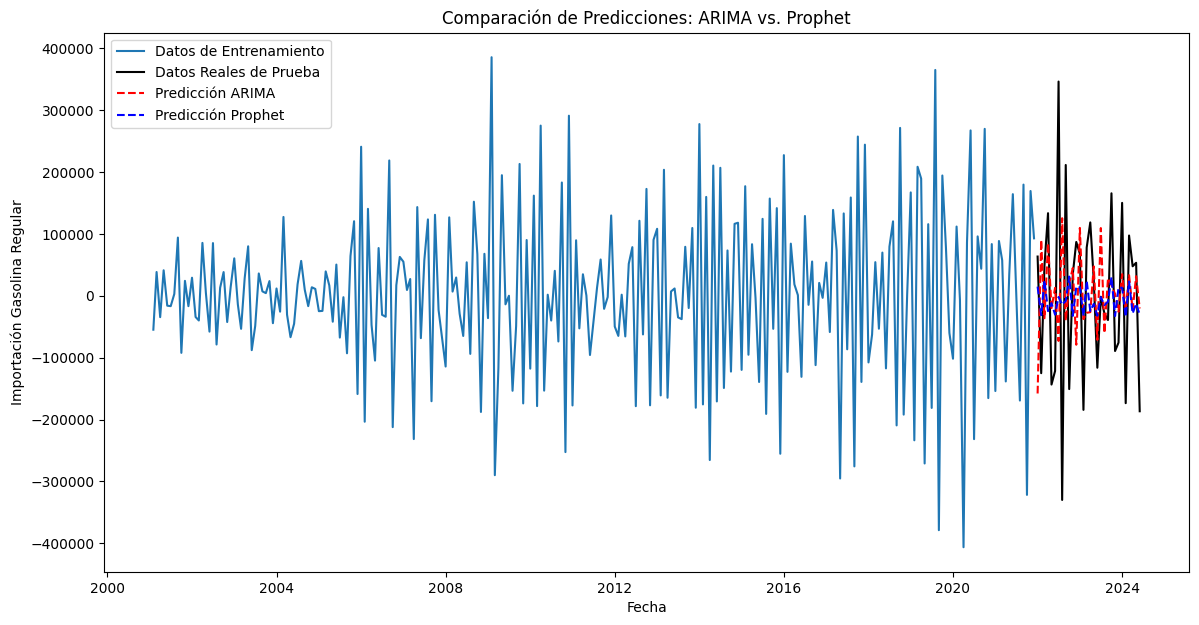

In [79]:
test['forecast_arima'] = np.nan
test.loc[test.index[-len(forecast_arima):], 'forecast_arima'] = forecast_arima

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Regular'], label='Datos de Entrenamiento')
plt.plot(test.index, test['Regular'], label='Datos Reales de Prueba', color='black')

plt.plot(test.index, test['forecast_arima'], label='Predicción ARIMA', linestyle='--', color='red')
plt.plot(test_prophet['ds'], test_prophet['forecast'], label='Predicción Prophet', linestyle='--', color='blue')

plt.legend()
plt.title('Comparación de Predicciones: ARIMA vs. Prophet')
plt.xlabel('Fecha')
plt.ylabel('Importación Gasolina Regular')
plt.show()


Acá empieza lo de silva

## 1.
Utilice los conjuntos de entrenamiento y prueba de una de las series que utilizó en el Laboratorio anterior.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cargar los datos
data = pd.read_csv('precio_promedio.csv', delimiter=';', parse_dates=['FECHA'], dayfirst=True)

# En este caso se usará la serie de precios de la gasolina superior
series = data['Superior'].values

# Normalizar los datos
series_max = np.max(series)
series_min = np.min(series)
series_normalized = (series - series_min) / (series_max - series_min)

def create_dataset(series, time_step=1):
    X, y = [], []
    for i in range(len(series) - time_step - 1):
        a = series[i:(i + time_step)]
        X.append(a)
        y.append(series[i + time_step])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(series_normalized, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2024-08-29 21:28:44.643178: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 21:28:44.756094: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 21:28:44.880665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 21:28:44.980936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 21:28:45.009159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 21:28:45.191265: I tensorflow/core/platform/cpu_feature_gu

In [2]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def create_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Crear el modelo KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'model__units': [50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 75],
    'batch_size': [32, 64]
}

# Realizar la búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_result = random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = random_search_result.best_params_
print(f"Mejores hiperparámetros para model1: {best_params}")

# Crear el modelo con los mejores hiperparámetros
model1 = create_model(units=best_params['model__units'], optimizer=best_params['model__optimizer'])
model1.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


2024-08-29 21:29:14.999804: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 21:29:15.007218: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 21:29:15.023676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Att2024-08-29 21:29:15.024065: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPempting to register factory for plugin cuFFT when one has already been registered
U will not be used.
2024-08-29 21:29:15.030197: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-29 21:29:15.049453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time=  35.4s
[CV] END batch_size=64, epochs=75, model__optimizer=adam, model__units=50; total time=  35.0s
[CV] END batch_size=64, epochs=75, model__optimizer=adam, model__units=50; total time=  35.4s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time=  35.1s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time=  35.7s
[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time=  36.8s
[CV] END batch_size=64, epochs=75, model__optimizer=adam, model__units=50; total time=  36.9s
[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time=  37.6s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time=  37.5s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  39.3s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  41.1s
[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  41.3s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time=  42.2s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time=  44.5s
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=100; total time=  45.1s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time=  48.7s
[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  29.2s
[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  31.8s
[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time=  32.3s
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=100; total time=  39.2s
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=100; total time=  39.7s
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=50; total time=  40.3s
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=50; total time=  35.2s
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=50; total time=  36.6s
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=50; total time=  42.8s
[CV] END batch_size=32, epochs=50, model__

I0000 00:00:1724988650.519106    2289 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-29 21:30:50.520784: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mejores hiperparámetros para model1: {'model__units': 50, 'model__optimizer': 'adam', 'epochs': 75, 'batch_size': 32}
Epoch 1/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1533 - val_loss: 0.0044
Epoch 2/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 3/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8793e-04 - val_loss: 0.0010
Epoch 11/75
33/33 ━━━━━━━━━━━━━━━━━━

In [3]:
def create_model_2(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Crear el modelo KerasRegressor
model_2 = KerasRegressor(build_fn=create_model_2, verbose=0)

# Realizar la búsqueda aleatoria
random_search_2 = RandomizedSearchCV(estimator=model_2, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search_result_2 = random_search_2.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_2 = random_search_result_2.best_params_
print(f"Mejores hiperparámetros para model2: {best_params_2}")

# Crear el modelo con los mejores hiperparámetros
model2 = create_model_2(units=best_params_2['model__units'], optimizer=best_params_2['model__optimizer'])
model2.fit(X_train, y_train, epochs=best_params_2['epochs'], batch_size=best_params_2['batch_size'], validation_data=(X_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``m

[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.1min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.1min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.2min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.2min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.p

[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time= 1.2min
[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.2min
[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time= 1.2min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.p

[CV] END batch_size=64, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.2min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=64, epochs=50, model__optimizer=adam, model__units=100; total time= 1.3min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.3min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.4min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.4min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=75, model__optimizer=rmsprop, model__units=50; total time= 1.5min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=100; total time= 2.0min


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=100; total time= 2.1min
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=100; total time= 2.2min


[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=50; total time= 1.1min
[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=50; total time= 1.1min


[CV] END batch_size=32, epochs=50, model__optimizer=adam, model__units=50; total time= 1.2min
[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time= 1.1min


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.4min
[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time= 1.1min


[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=100; total time= 1.4min
[CV] END batch_size=32, epochs=50, model__optimizer=rmsprop, model__units=50; total time= 1.1min


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time= 1.4min


[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time= 1.4min
[CV] END batch_size=64, epochs=75, model__optimizer=rmsprop, model__units=100; total time= 1.4min
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=50; total time= 1.4min
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=50; total time= 1.4min
[CV] END batch_size=32, epochs=75, model__optimizer=adam, model__units=50; total time=  56.9s


/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/silva/.local/share/virtualenvs/Lab2_DS-LnozbaEm/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Mejores hiperparámetros para model2: {'model__units': 100, 'model__optimizer': 'adam', 'epochs': 75, 'batch_size': 32}
Epoch 1/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0888 - val_loss: 0.0030
Epoch 2/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 5/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5058e-04 - val_loss: 0.0011
Epoch 7/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5484e-04 - val_loss: 0.0011
Epoch 8/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.5940e-04 - val_loss: 0.0011
Epoch 9/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.1965e-04 - val_loss: 0.0011
Epoch 10/75
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 11/75
33

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5474e-04 
Loss del modelo 1: 0.00039741722866892815
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7925e-04 
Loss del modelo 2: 0.0003060982853639871
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Valores máximos de las predicciones: 43.215579986572266


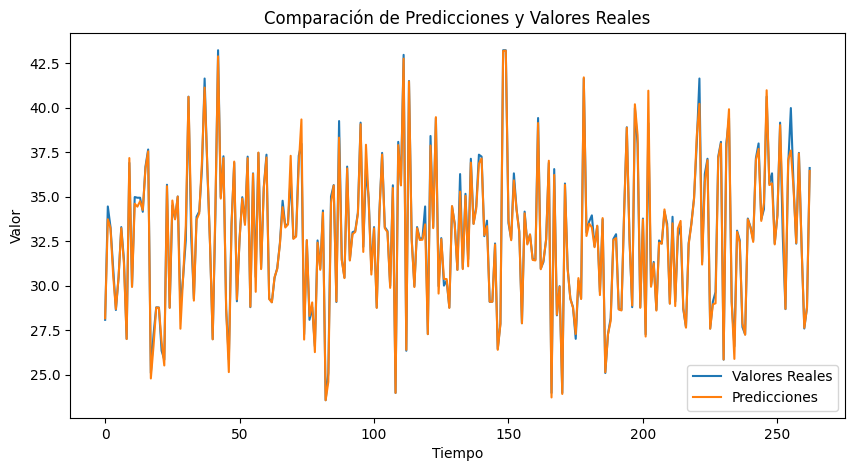

In [4]:
import matplotlib.pyplot as plt

# Evaluar el modelo 1
loss1 = model1.evaluate(X_test, y_test)
print(f'Loss del modelo 1: {loss1}')

# Evaluar el modelo 2
loss2 = model2.evaluate(X_test, y_test)
print(f'Loss del modelo 2: {loss2}')

# Seleccionar el mejor modelo
if loss1 < loss2:
    best_model = model1
else:
    best_model = model2

# Hacer predicciones con el mejor modelo
predictions_normalized = best_model.predict(X_test)

# Desnormalizar las predicciones
predictions = predictions_normalized * (series_max - series_min) + series_min

# Verificar los valores máximos de las predicciones
print(f'Valores máximos de las predicciones: {np.max(predictions)}')

# Graficar las predicciones junto con los valores reales
plt.figure(figsize=(10, 5))
plt.plot(y_test * (series_max - series_min) + series_min, label='Valores Reales')
plt.plot(predictions, label='Predicciones')
plt.legend()
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()